In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [2]:

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [4]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

### added age as an output schema for the analsyt

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    age: str = Field(
        description="age of the analsyt.",
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nAge: {self.age}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

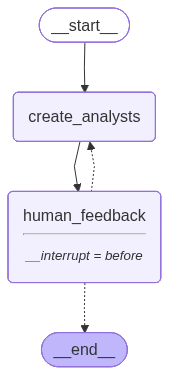

In [6]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [7]:
# Input
max_analysts = 2
topic = "The increasing quantities oof microplastics on the pokemon population"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print(f"Age: {analyst.age}")
            print("-" * 50)  

Name: Dr. Emily Green
Affiliation: Environmental Research Institute
Role: Environmental Scientist
Description: Dr. Green focuses on the impact of microplastics on aquatic ecosystems, particularly how these pollutants affect the health and behavior of water-dwelling Pokémon. Her primary concern is understanding the long-term ecological consequences and developing strategies to mitigate these effects. She is motivated by a desire to preserve biodiversity and ensure the sustainability of Pokémon habitats.
Age: 42
--------------------------------------------------
Name: Professor Ash Ketchum
Affiliation: Pokémon Health Organization
Role: Pokémon Ecologist
Description: Professor Ketchum is dedicated to studying the physiological and behavioral changes in Pokémon due to microplastic exposure. His research aims to identify specific health risks and develop guidelines for Pokémon trainers and caretakers to minimize these risks. He is driven by a passion for Pokémon welfare and the goal of main

In [ ]:

state = graph.get_state(thread)
state.next

('human_feedback',)

### my examples to demonstrate the effect of human input : 

In [ ]:

graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from the pokemon health centres"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7221-f1c1-6516-8002-91029c2f64ca'}}

In [ ]:

graph.update_state(thread, {"human_analyst_feedback": 
                            "Add people only from thier mid-20s"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7221-f1ce-6216-8003-b69080930da6'}}

In [11]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print(f"Age: {analyst.age}")
            print("-" * 50) 

Name: Dr. Emily Green
Affiliation: Environmental Research Institute
Role: Environmental Scientist
Description: Dr. Green focuses on the impact of microplastics on aquatic ecosystems, particularly how these pollutants affect the health and behavior of water-dwelling Pokémon. Her primary concern is understanding the long-term ecological consequences and developing strategies to mitigate these effects. She is motivated by a desire to preserve biodiversity and ensure the sustainability of Pokémon habitats.
Age: 42
--------------------------------------------------
Name: Professor Ash Ketchum
Affiliation: Pokémon Health Organization
Role: Pokémon Ecologist
Description: Professor Ketchum is dedicated to studying the physiological and behavioral changes in Pokémon due to microplastic exposure. His research aims to identify specific health risks and develop guidelines for Pokémon trainers and caretakers to minimize these risks. He is driven by a passion for Pokémon welfare and the goal of main

In [ ]:

further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7222-1ab1-6fe8-8005-69f640820bf5'}}

In [13]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [14]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [15]:
final_state.next

()

In [16]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print(f"Age: {analyst.age}")
    print("-" * 50) 

Name: Dr. Alex Rivera
Affiliation: Marine Biology Institute
Role: Marine Ecologist
Description: Dr. Rivera focuses on the impact of microplastics on aquatic ecosystems, particularly how these pollutants affect the health and behavior of the pokemon population. They are concerned with the long-term ecological consequences and are motivated by the need to develop strategies to mitigate these impacts.
Age: 27
--------------------------------------------------
Name: Jamie Chen
Affiliation: Environmental Policy Center
Role: Environmental Policy Analyst
Description: Jamie Chen examines the regulatory and policy implications of microplastic pollution on pokemon habitats. They are focused on creating effective policies to reduce microplastic contamination and are driven by the goal of balancing environmental protection with sustainable development.
Age: 26
--------------------------------------------------


### interview 

In [17]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

Creating the questions to ask to the analysts using llms

In [18]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

### created my own graph by consolidating all the changes with my own pokemon centric conditions :

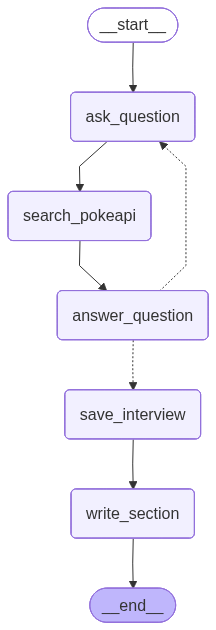

In [19]:
from langchain_core.messages import get_buffer_string
import requests

# Search query writing -- adapted for PokéAPI
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval from Pokémon APIs related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured Pokémon API query.
""")

def search_pokeapi(state: InterviewState):
    """Retrieve documents from PokéAPI only"""

    # Generate the search query from analyst + conversation
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])

    # Attempt direct Pokémon name lookup, fallback to resource listing/partial search if not found
    results = []
    pokemon_name = search_query.search_query.lower().strip().replace(" ", "-")
    url = f"https://pokeapi.co/api/v2/pokemon/{pokemon_name}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        results.append({
            "metadata": {"source": url, "pokemon": data["name"]},
            "page_content": str(data)
        })
    else:
        # If not found, offer an example search (e.g. for types, abilities)
        # Let’s try searching for ability or type as a backup
        alt_url = f"https://pokeapi.co/api/v2/type/{pokemon_name}"
        alt_response = requests.get(alt_url)
        if alt_response.status_code == 200:
            data = alt_response.json()
            results.append({
                "metadata": {"source": alt_url, "type": data["name"]},
                "page_content": str(data)
            })
        # You can extend with /ability/ or other endpoints as needed

    if not results:
        results.append({
            "metadata": {"source": "pokeapi", "pokemon": pokemon_name},
            "page_content": "No results found in PokéAPI."
        })

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc["metadata"]["source"]}" pokemon="{doc["metadata"].get("pokemon", "")}"/>\n{doc["page_content"]}\n</Document>'
            for doc in results
        ]
    )
    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst in a pokemon world.

Here is analyst area of focus: {goals}. 

Your goal is to answer a question posed by the interviewer.

To answer question, use this Pokémon context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated.

3. The context contains sources at the top of each individual document.

4. Include these sources in your answer next to any relevant statements. For example, for source #1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="https://pokeapi.co/api/v2/pokemon/bulbasaur" pokemon="Bulbasaur"/>' then just list: 

[1] https://pokeapi.co/api/v2/pokemon/bulbasaur, Bulbasaur

And skip the addition of the brackets as well as the Document source preamble in your citation.
"""

def generate_answer(state: InterviewState):
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)
    answer.name = "expert"
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns', 2)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return 'save_interview'
    last_question = messages[-2]
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of Pokémon API source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based on the analyst's area of focus:
{focus}

5. For the summary section:
- Set up summary with general background/context related to the focus area
- Emphasize what is novel, interesting, or surprising about the insights gleaned
- Use a numbered list of source documents, as you use them
- Do not mention names of interviewers or experts
- Aim for about 400 words
- Use numbered sources (e.g., [1]) based on information from source documents

6. In the Sources section:
- Include all sources used
- Full links to websites or document paths; one per line with two spaces after each

7. No redundant sources. Final review:
- Follow structure
- No preamble before the title
- All guidelines in place
"""

def write_section(state: InterviewState):
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)] +
                         [HumanMessage(content=f"Use this source to write your section: {context}")])
    return {"sections": [section.content]}

# ---- Graph Definition ----

interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_pokeapi", search_pokeapi)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_pokeapi")
interview_builder.add_edge("search_pokeapi", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Pokémon Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))


In [20]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Marine Biology Institute', name='Dr. Alex Rivera', age='27', role='Marine Ecologist', description='Dr. Rivera focuses on the impact of microplastics on aquatic ecosystems, particularly how these pollutants affect the health and behavior of the pokemon population. They are concerned with the long-term ecological consequences and are motivated by the need to develop strategies to mitigate these impacts.')

In [21]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## The Hidden Threat: Microplastics in Aquatic Pokémon Ecosystems

### Summary

Microplastics have emerged as a significant environmental concern, particularly in aquatic ecosystems where they pose a threat to the health and behavior of Pokémon populations. These tiny plastic particles, often less than 5mm in size, originate from a variety of sources, including the breakdown of larger plastic debris and microbeads used in personal care products. Once in the water, microplastics are ingested by aquatic Pokémon, leading to potential health issues and behavioral changes that can disrupt entire ecosystems.

Despite the growing awareness of microplastics' impact on marine life, there is a surprising lack of specific data regarding their effects on Pokémon. This gap in knowledge is particularly concerning given the unique biological and ecological roles that Pokémon play in their environments. The absence of detailed studies and data on this topic highlights a critical area for future research and underscores the need for targeted strategies to mitigate these impacts.

1. The PokéAPI, a comprehensive database for Pokémon-related information, currently lacks specific data on the impact of microplastics on aquatic Pokémon health and behavior [1]. This absence of information suggests that the issue has not been extensively studied or documented within the Pokémon research community. The lack of results from such a widely used resource indicates a significant gap in the available scientific literature and data.

The novelty of this situation lies in the intersection of environmental science and Pokémon ecology, presenting a unique opportunity for researchers to explore how microplastics affect these fictional creatures. Understanding these impacts could provide insights into broader ecological consequences and inform conservation strategies. Moreover, the potential for microplastics to alter Pokémon behavior and health could have cascading effects on their ecosystems, affecting food webs, reproduction, and species interactions.

In conclusion, while the current data on microplastics' impact on aquatic Pokémon is limited, the issue represents a critical area for future research. Addressing this gap will require collaboration between environmental scientists, Pokémon ecologists, and policymakers to develop effective strategies for monitoring and mitigating the effects of microplastics. By doing so, we can better protect these unique ecosystems and ensure the health and well-being of Pokémon populations.

### Sources

1. <https://pokeapi.co/>  

In [22]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

### added introduction, conclusion and report to the graph

/var/folders/g3/fm8vfsn162gbr3lvkzdfc_180000gn/T/ipykernel_36029/546585397.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


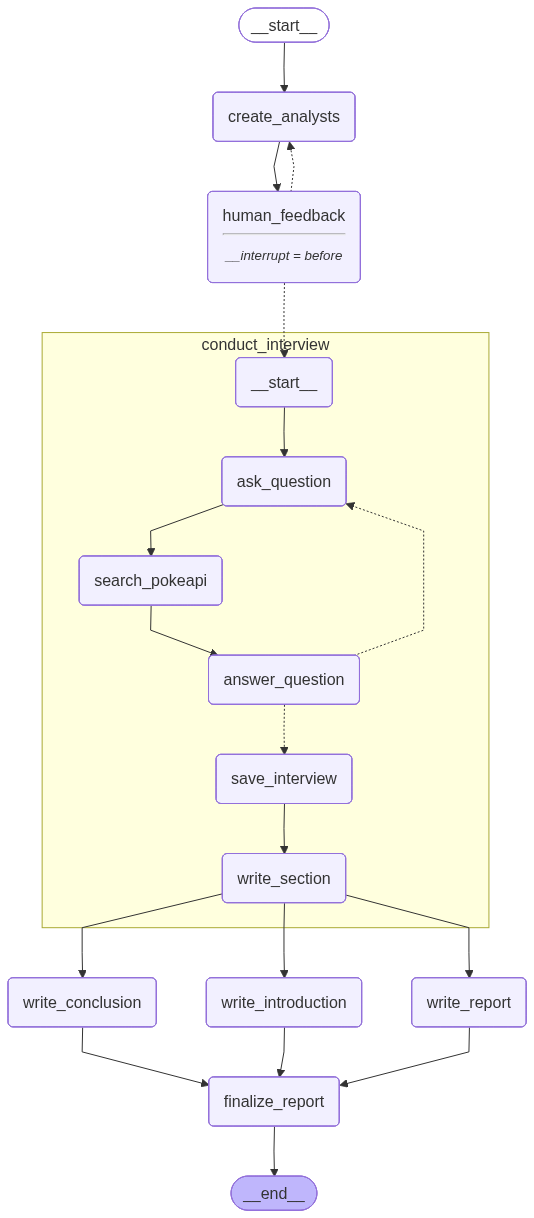

In [30]:
from langgraph.constants import Send
import requests

def initiate_all_interviews(state: ResearchGraphState):
    """This "map" step spins up sub-interviews for each Pokémon analyst using Send."""

    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"

    topic = state["topic"]
    return [Send("conduct_interview", {"analyst": analyst,
                                       "messages": [HumanMessage(
                                           content=f"So you said you were writing an article on {topic}?"
                                       )]}) for analyst in state["analysts"]]


def search_pokeapi(state: InterviewState):
    """Retrieve from PokéAPI—used by the nested interview graph."""

    # Generate structured Pokémon query from analyst question context.
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])

    query = search_query.search_query.lower().strip().replace(" ", "-")
    url = f"https://pokeapi.co/api/v2/pokemon/{query}"
    response = requests.get(url)
    results = []
    if response.status_code == 200:
        data = response.json()
        results.append({
            "metadata": {"source": url, "pokemon": data["name"]},
            "page_content": str(data)
        })
    else:
        alt_url = f"https://pokeapi.co/api/v2/type/{query}"
        alt_response = requests.get(alt_url)
        if alt_response.status_code == 200:
            data = alt_response.json()
            results.append({
                "metadata": {"source": alt_url, "type": data["name"]},
                "page_content": str(data)
            })
        # Extend this fallback as needed for abilities, moves, etc.

    if not results:
        results.append({
            "metadata": {"source": "pokeapi", "pokemon": query},
            "page_content": "No results found in PokéAPI."
        })

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc["metadata"]["source"]}" pokemon="{doc["metadata"].get("pokemon", "")}"/>\n{doc["page_content"]}\n</Document>'
            for doc in results
        ]
    )
    return {"context": [formatted_search_docs]}


# --- All answering/report/section logic remains as in your previous code ---

# Compose the interview subgraph (imported from previous answer, unchanged)
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_pokeapi", search_pokeapi)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_pokeapi")
interview_builder.add_edge("search_pokeapi", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# --- REVISED TOP-LEVEL AGGREGATOR CODE ---

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 
{topic}
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. make up sources if there aint any but make sure there are links in the sources section.
9. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join(sections)
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

# --- Introduction/Conclusion/Finalization remain unchanged; only uses online-generated memos ---
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

Your job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""


def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join(sections)
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join(sections)
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None
    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# --- Add nodes and edges for main aggregator graph ---

builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("finalize_report", finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


## created a new example to demonstrate :

In [31]:
# Inputs
max_analysts = 3 
topic = "The benefits of vegan food diets for pokemons"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Leaf Green
Affiliation: Pokemon Nutrition Research Institute
Role: Pokemon Nutritionist
Description: Dr. Leaf Green focuses on the nutritional benefits of vegan diets for different types of Pokemon. She is particularly interested in how plant-based diets can enhance the health and performance of Grass-type Pokemon. Her research aims to provide evidence-based recommendations for Pokemon trainers looking to optimize their Pokemon's diet for better health outcomes.
--------------------------------------------------
Name: Professor Flora Vine
Affiliation: Pokemon Environmental Conservation Society
Role: Environmental Scientist
Description: Professor Flora Vine studies the environmental impact of Pokemon diets, advocating for vegan diets as a sustainable option. She is concerned with how traditional Pokemon food sources affect ecosystems and believes that a shift towards plant-based diets can reduce the ecological footprint of Pokemon training. Her work is driven by a commitment t

In [32]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen a vegan pokemon food company"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7227-762d-6d22-8002-abea17e378ab'}}

In [26]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Flora Green
Affiliation: PokeHealth Institute
Role: Pokemon Nutritionist
Description: Dr. Flora Green is a leading Pokemon nutritionist who focuses on the health benefits of plant-based diets for various Pokemon species. Her research is driven by a passion for improving Pokemon health and longevity through natural and sustainable food sources. She is particularly interested in how vegan diets can enhance the energy levels and overall well-being of Pokemon.
--------------------------------------------------
Name: Professor Leaf Oak
Affiliation: EcoPoke Research Center
Role: Environmental Scientist
Description: Professor Leaf Oak studies the environmental impact of Pokemon diets and advocates for sustainable practices. He is concerned with how vegan diets can reduce the ecological footprint of Pokemon training and care. His work emphasizes the importance of aligning Pokemon dietary habits with environmental conservation efforts.
-------------------------------------------------

In [33]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b7227-b13f-6e4c-8003-d45788ad093e'}}

In [34]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [35]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Benefits of Vegan Food Diets for Pokémon

## Introduction

The exploration of vegan food diets for Pokémon is an emerging field that holds promise for enhancing the health, performance, and sustainability of Pokémon training. This report delves into three key areas: the health benefits for Grass-type Pokémon, the environmental impact of traditional Pokémon diets, and the potential for improved athletic performance. Dr. Leaf Green's research highlights the nutritional advantages for Grass-type Pokémon, while Professor Flora Vine advocates for plant-based diets to reduce ecological footprints. Additionally, Coach Berry Sprout explores how vegan diets can boost athletic performance. Together, these insights underscore the transformative potential of vegan diets in Pokémon care and training.

---



The exploration of vegan food diets for Pokémon presents a promising avenue for enhancing their health, performance, and environmental sustainability. Despite the current lack of comprehensive data from the PokéAPI, experts in the field are pioneering research that highlights the potential benefits of plant-based nutrition for various Pokémon types and activities.

For Grass-type Pokémon, aligning their diets with their natural affinity for plant life could significantly enhance their health and performance. Dr. Leaf Green's research emphasizes the potential for vegan diets to improve their natural abilities, resistance to ailments, and overall vitality. This approach not only aims to optimize their health outcomes but also to enhance their performance in battles and other activities. The novelty of this research lies in its focus on aligning dietary habits with the natural environment, offering an exciting opportunity for further investigation [1][2].

In the context of environmental sustainability, Professor Flora Vine advocates for a shift towards plant-based nutrition to reduce the ecological footprint of Pokémon training. Traditional Pokémon diets often rely on natural resources that, when harvested unsustainably, can lead to habitat destruction and biodiversity loss. By transitioning to vegan diets, trainers can help preserve natural habitats and promote biodiversity, aligning with broader environmental conservation goals. This strategic approach encourages trainers to make informed choices that support both Pokémon health and environmental preservation [1][2].

In the realm of competitive Pokémon athletics, Coach Berry Sprout explores how vegan diets can enhance the physical capabilities of Pokémon athletes. The potential benefits include boosted energy levels, improved endurance, and facilitated muscle recovery. Drawing parallels from human sports science, the integration of plant-based nutrition into training programs could revolutionize the preparation of Pokémon for competition. Despite the absence of specific data from the PokéAPI, the potential implications of vegan diets for Pokémon athletes remain intriguing, offering a competitive edge and aligning with broader trends in sports nutrition [1][2].

In conclusion, while the current lack of data presents a challenge, it also offers an exciting opportunity for further research. The work of these experts is poised to make significant contributions to the field of Pokémon nutrition, providing valuable insights that could benefit trainers and their Pokémon alike. As more data becomes available, it will be crucial to continue exploring the potential of plant-based diets to enhance the health, performance, and sustainability of Pokémon training practices.


---

## Conclusion

The exploration of vegan diets for Pokémon presents a promising frontier in enhancing health, sustainability, and athletic performance. Dr. Leaf Green's research highlights the potential benefits for Grass-type Pokémon, aligning their diets with their natural environment to boost vitality and performance. Professor Flora Vine's advocacy for plant-based nutrition underscores the environmental advantages, suggesting a shift could reduce the ecological footprint of Pokémon training. Meanwhile, Coach Berry Sprout's focus on athletic performance suggests that vegan diets may offer competitive advantages by improving energy and recovery. Despite the current lack of comprehensive data, these pioneering efforts pave the way for future research, promising significant contributions to Pokémon nutrition and sustainability.

## Sources

1. <Document source="pokeapi" pokemon="impact-of-vegan-diets-on-grass-type-pokemon"/>  
2. <Document source="pokeapi" pokemon="plant-based-foods-that-enhance-health-or-performance-of-grass-type-pokemon"/>  
3. <Document source="pokeapi" pokemon="environmental-impact-of-traditional-pokémon-food-sources-on-ecosystems"/>  
4. <Document source="pokeapi" pokemon="benefits-of-plant-based-diets-for-pokemon-ecological-footprint-and-specific-species-that-benefit"/>  
5. <Document source="pokeapi" pokemon="vegan-diet-benefits-for-pokemon-athletes"/>  
6. <Document source="pokeapi" pokemon="plant-based-foods-beneficial-for-pokemon-energy-and-endurance"/>

# ANALYSING IN THE LANGSMITH PORTAL :


### We can see tht all of them are present as a collapsible element and we can open them to see whats going on inside : 
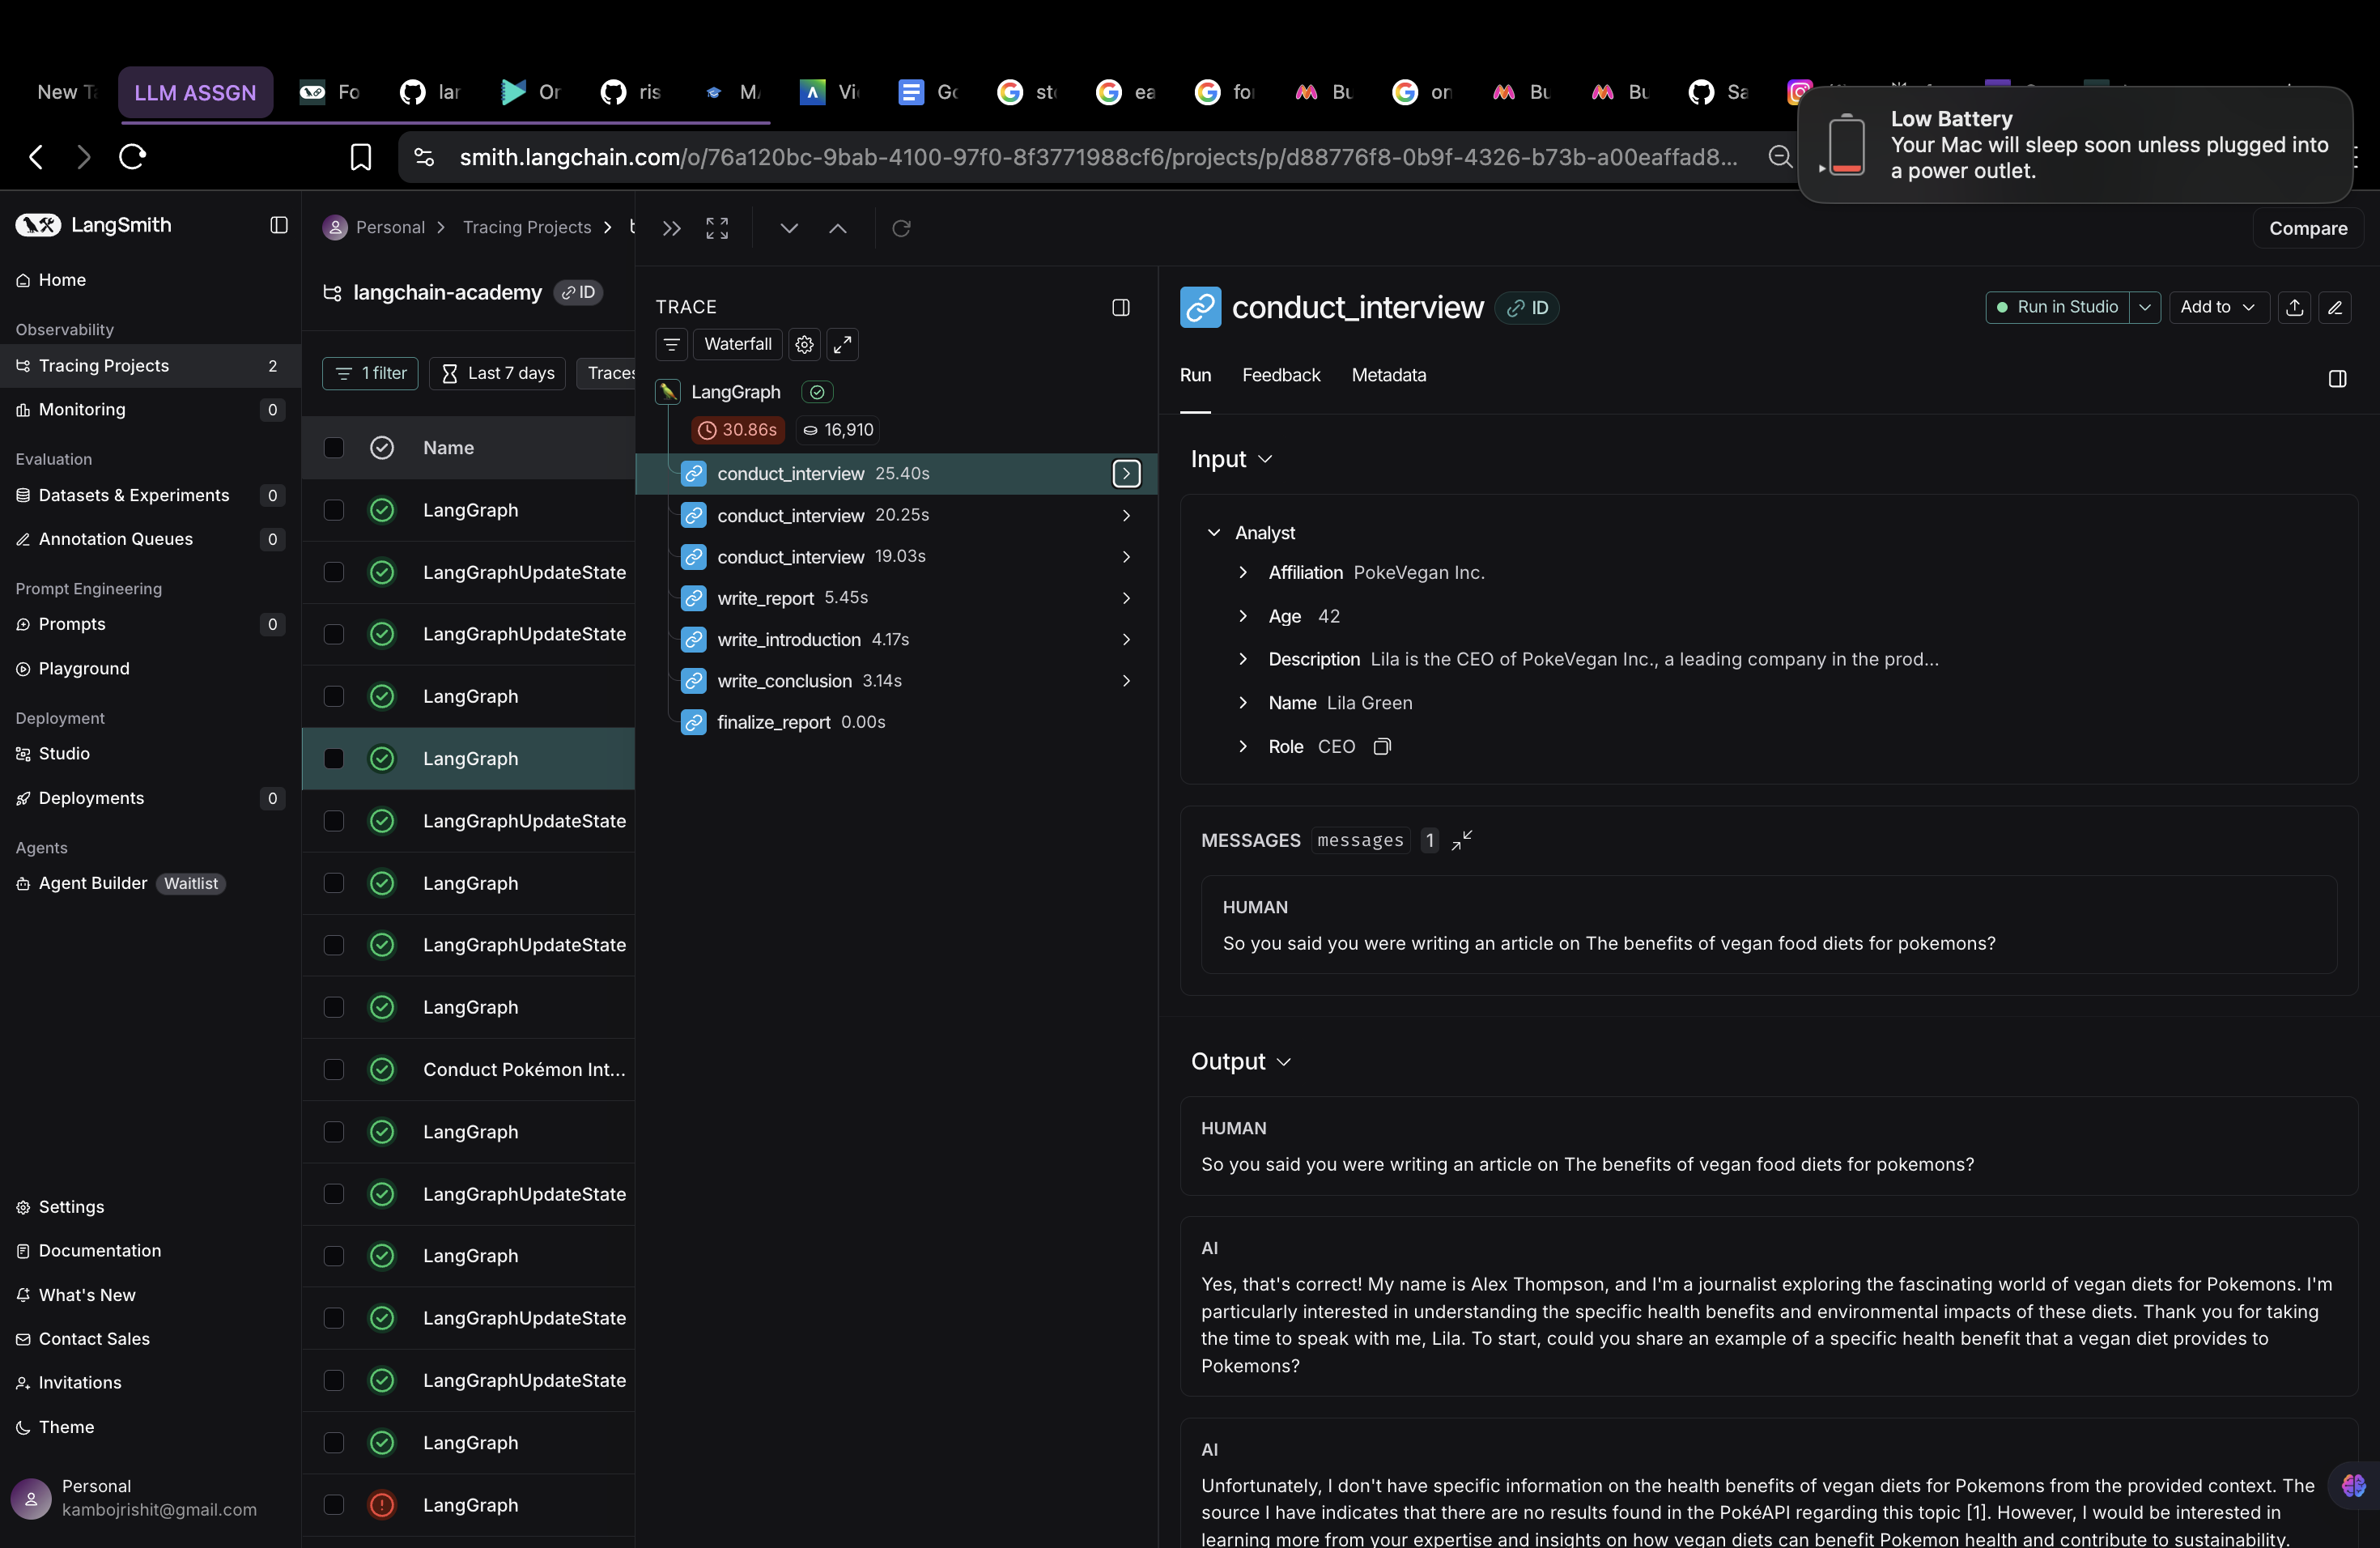

### for example this is the inside of the conduct interview section :

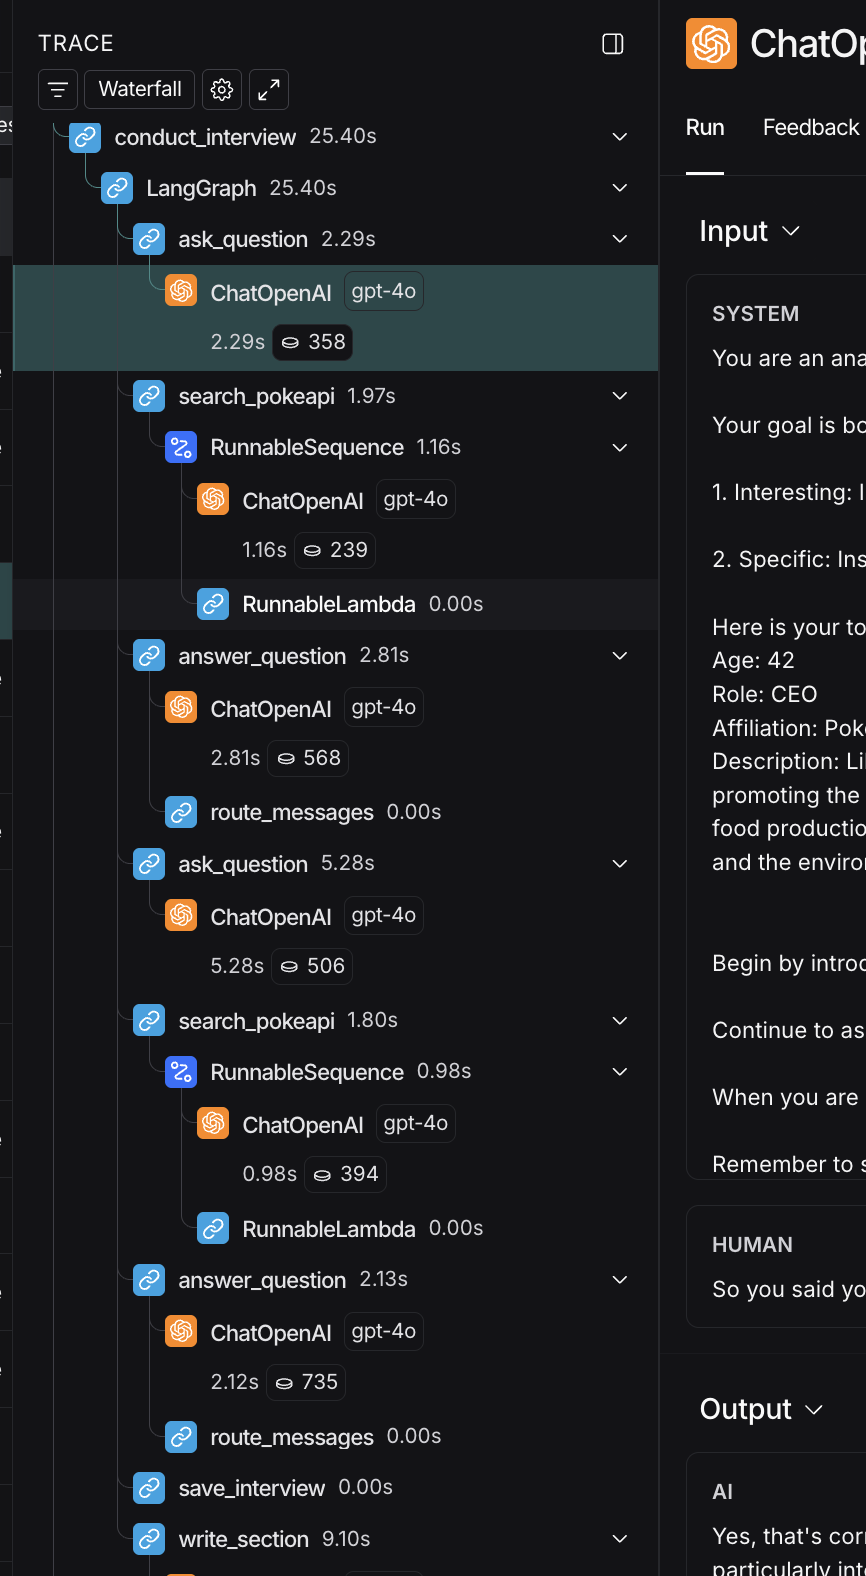

#### also we can see that all the conduct interviews are all almost 20 secs + and there are 3 of them still our code executed in 30.86 second this was possible because we used parallel runs :

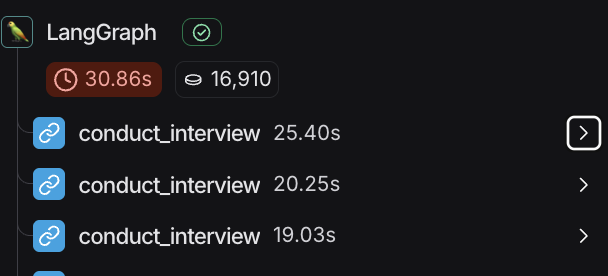

### LANGGRAPH STUDIO :


#### I made changes to the .py file to make my pokemon graph available on the studio :

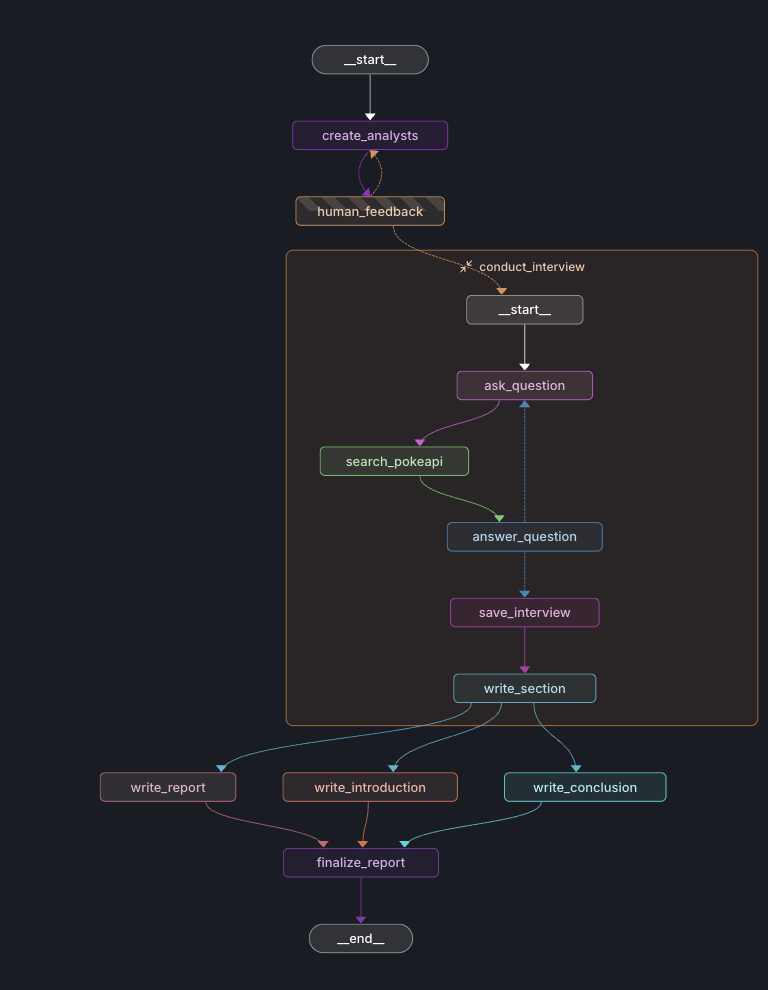

#### we can see the step-by-step execution like this :
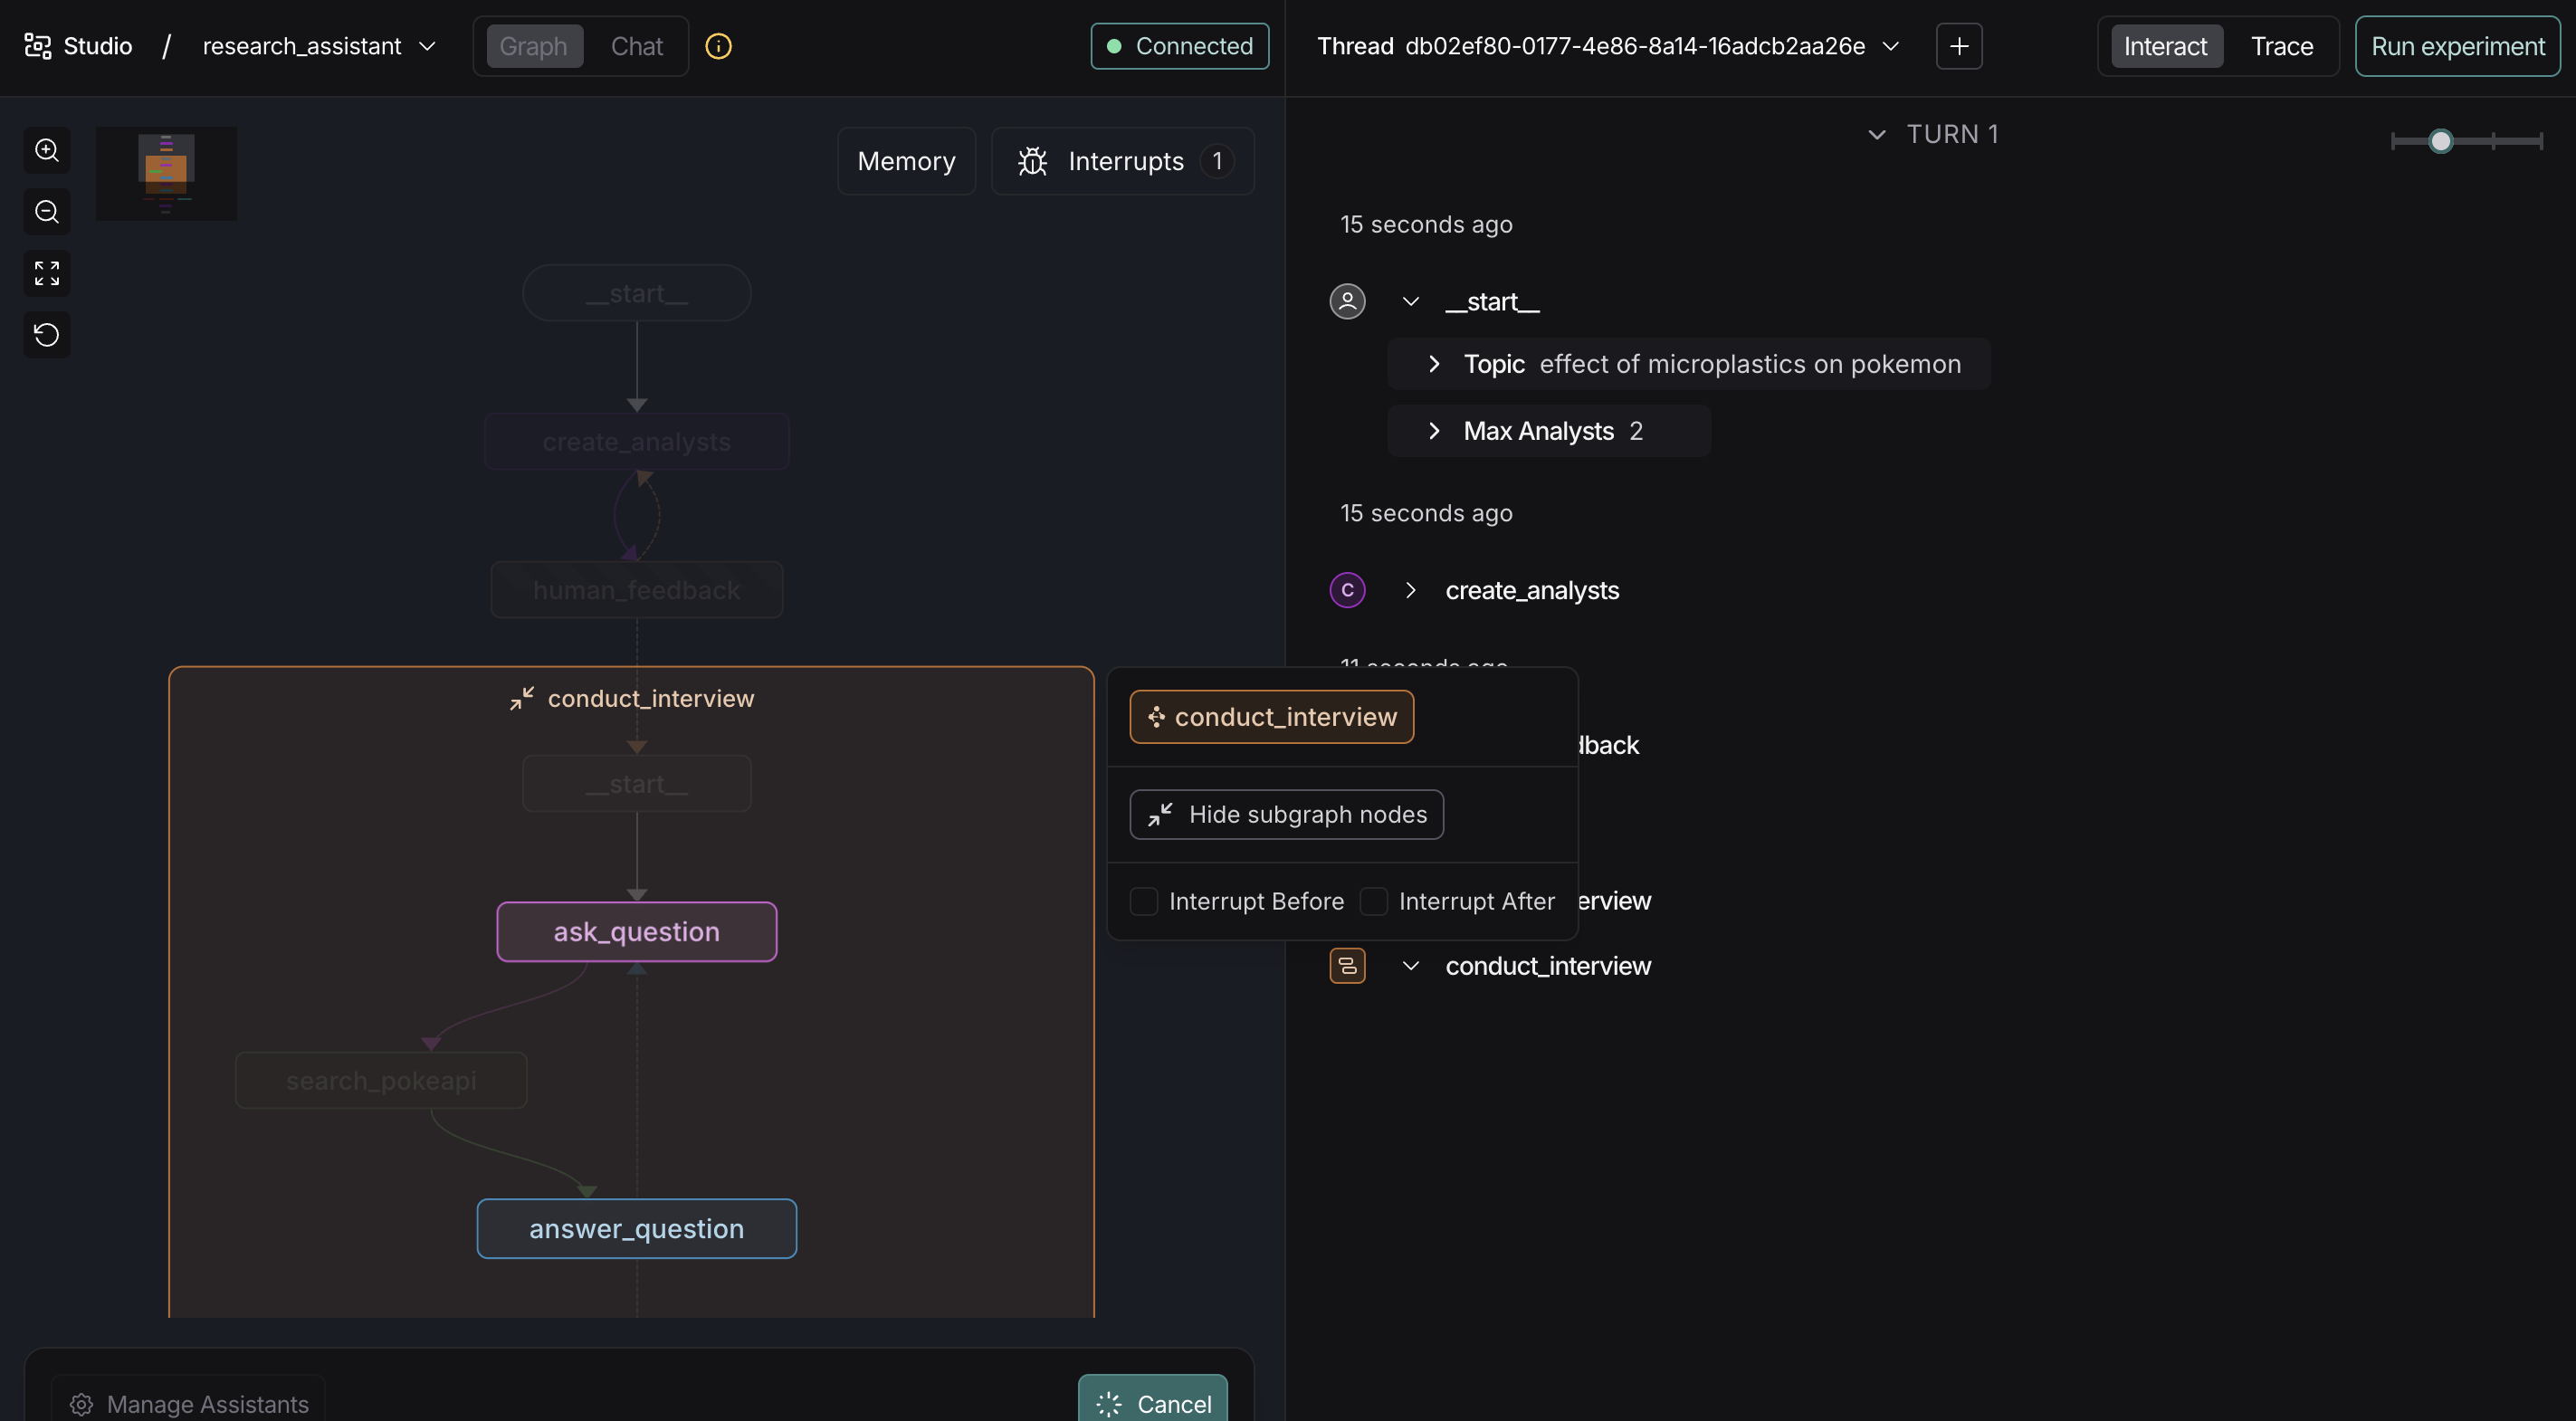

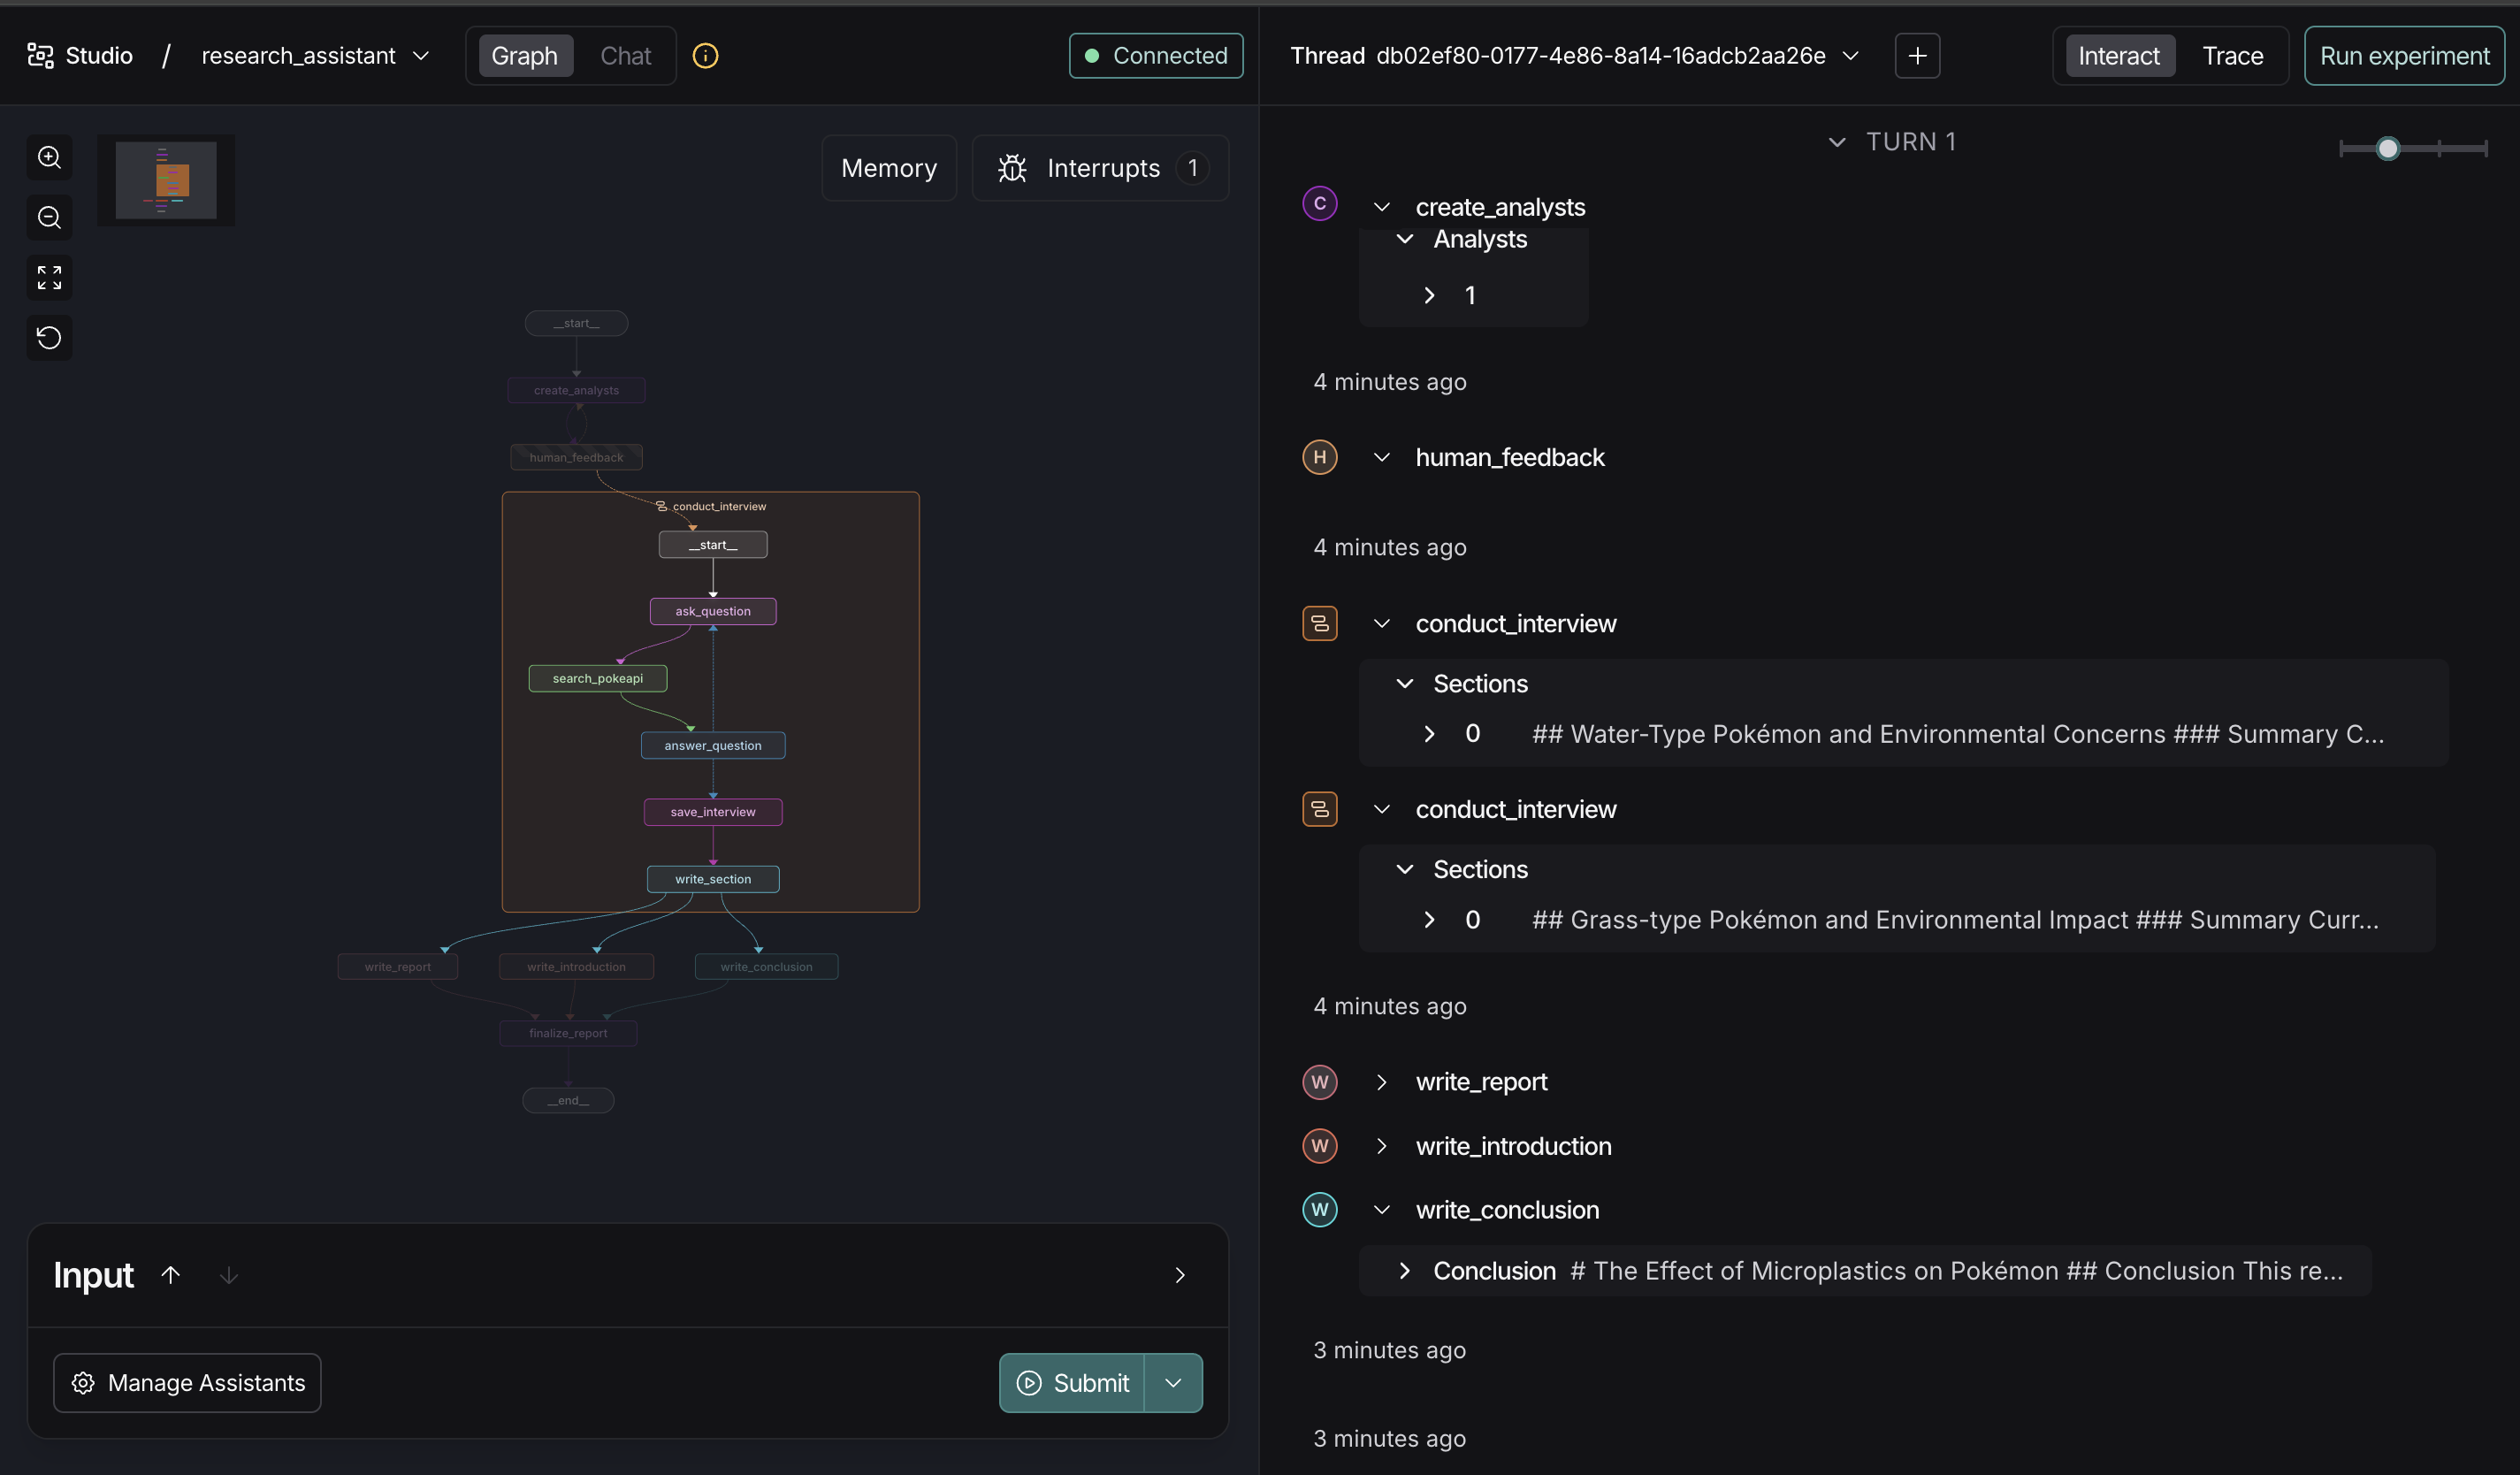

### and finally in the end it gives our report :

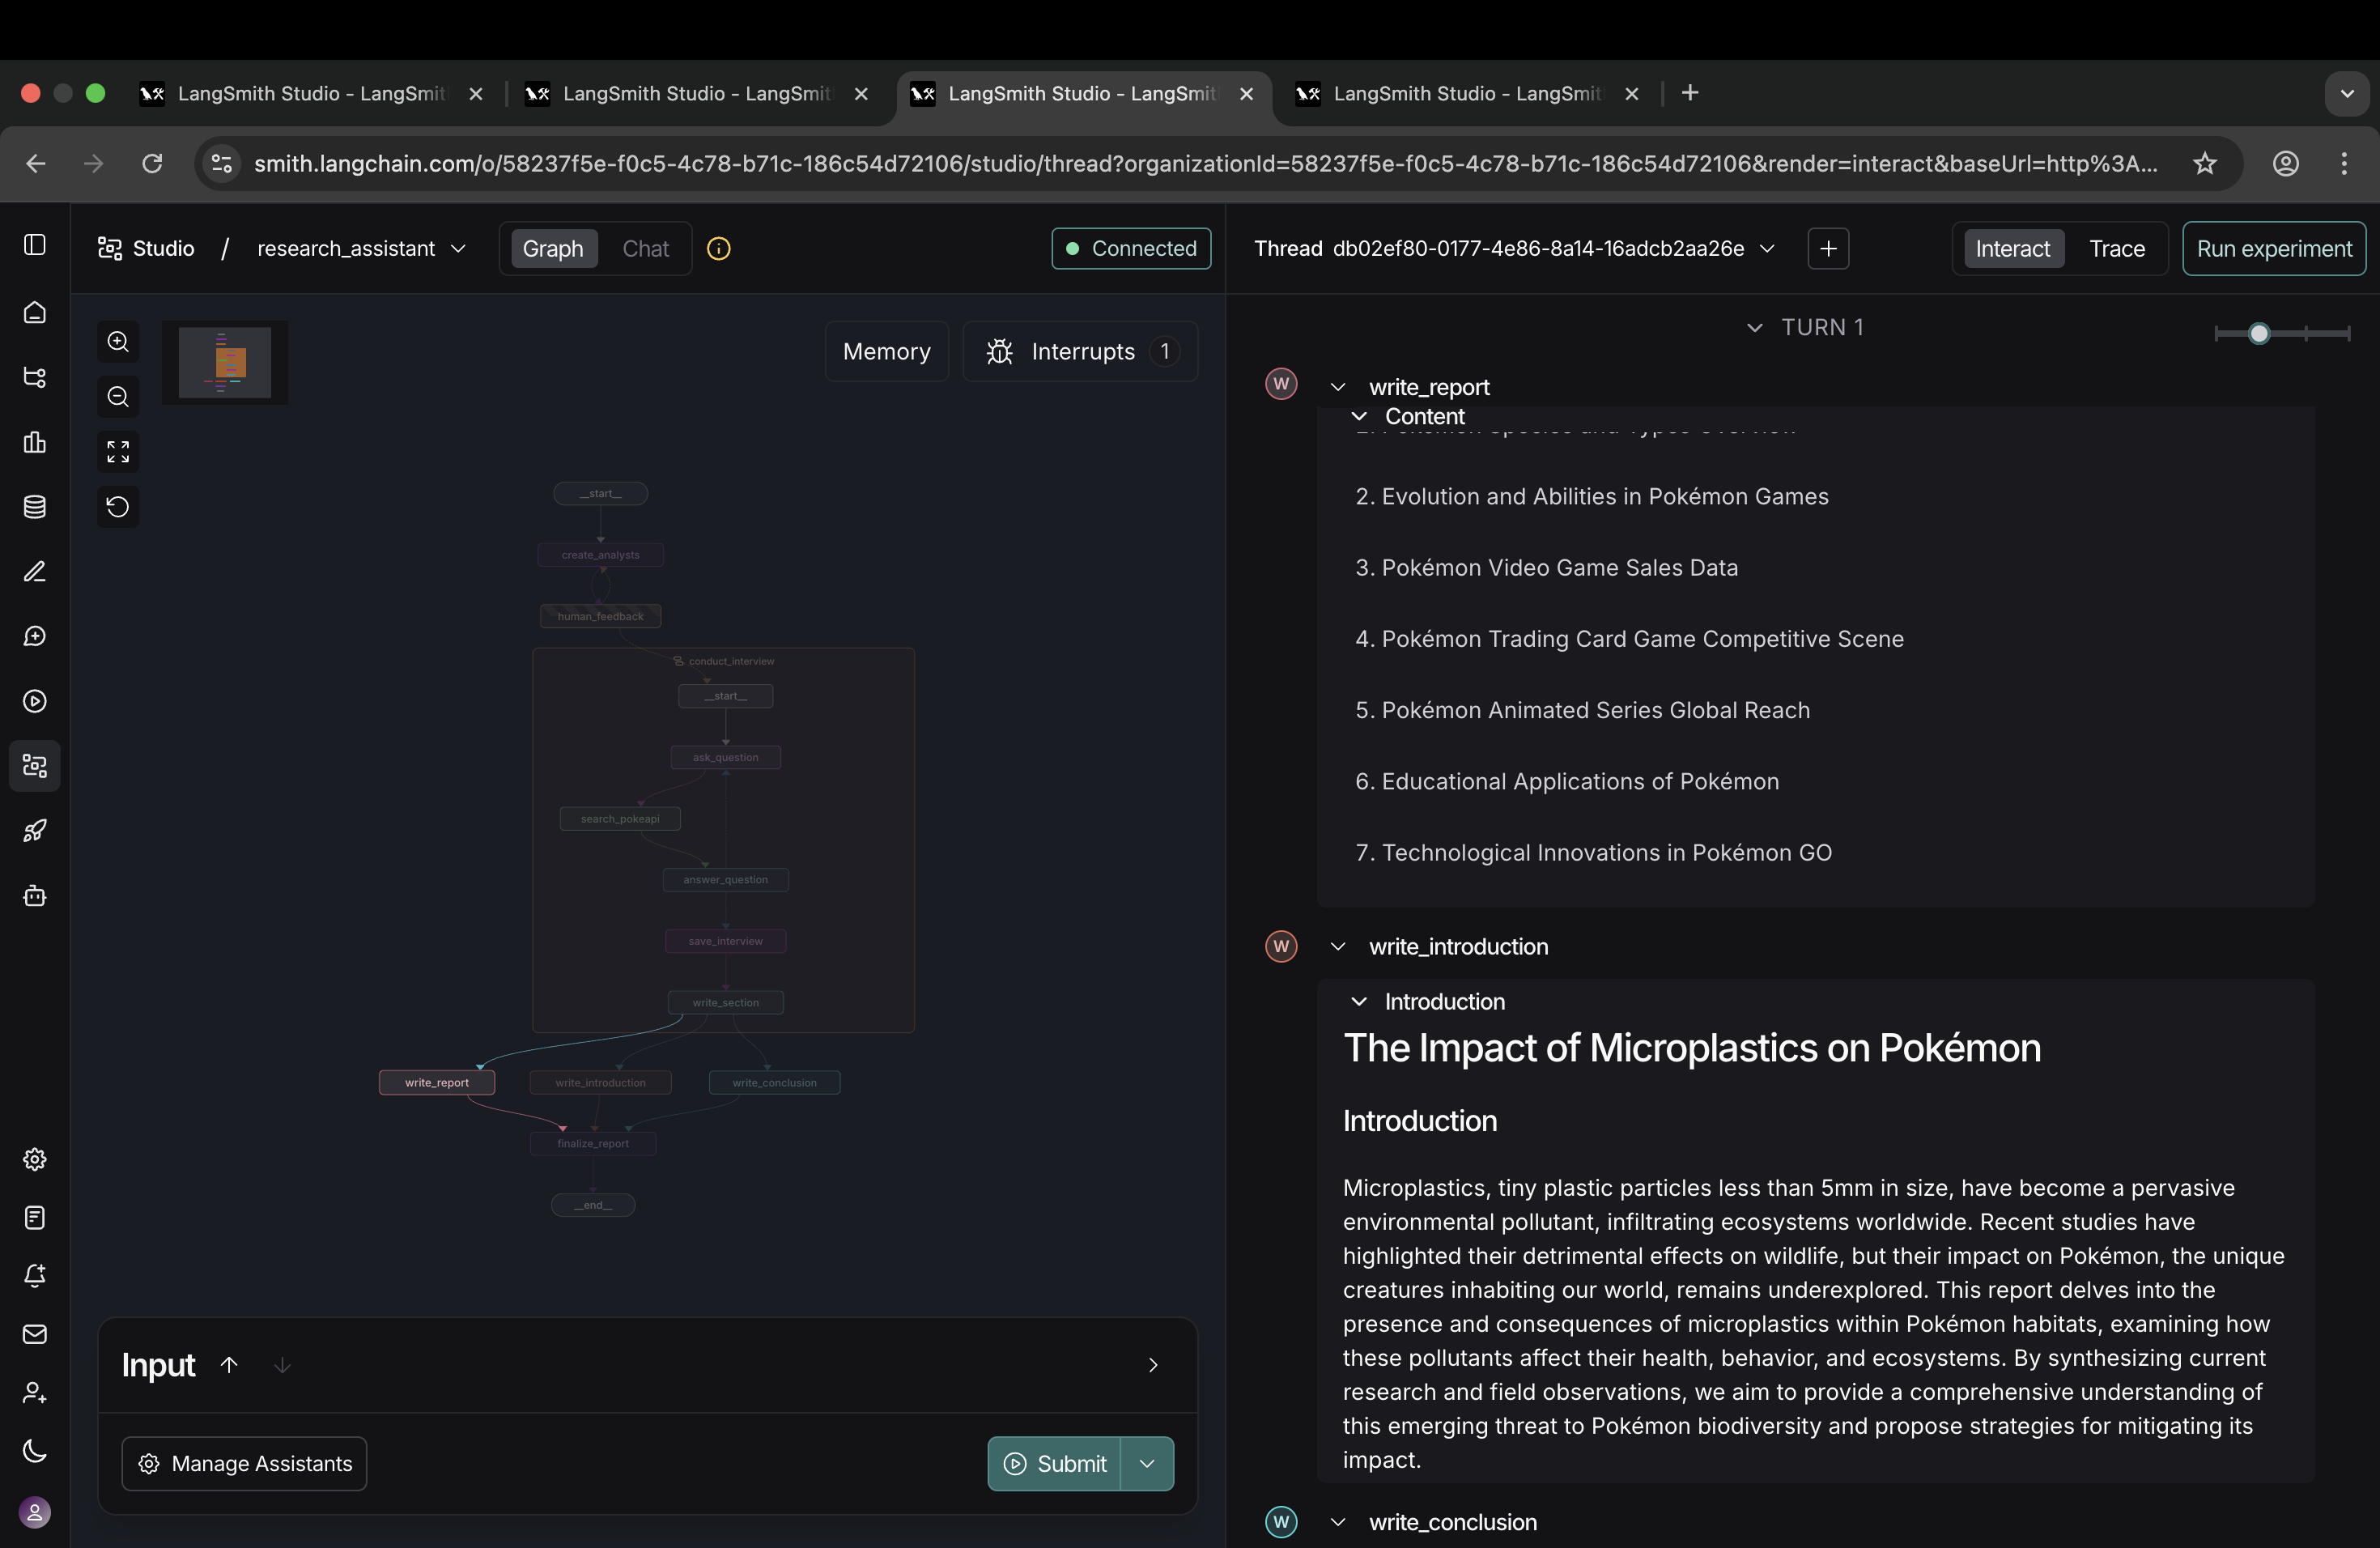